τ: 85.8000 s
T @ τ: 184.72 C
b0: 0.0199
beta1: 0.0256
beta2: 0.000149
kr: 1.6617
kr alternate, via b0: 0.5861


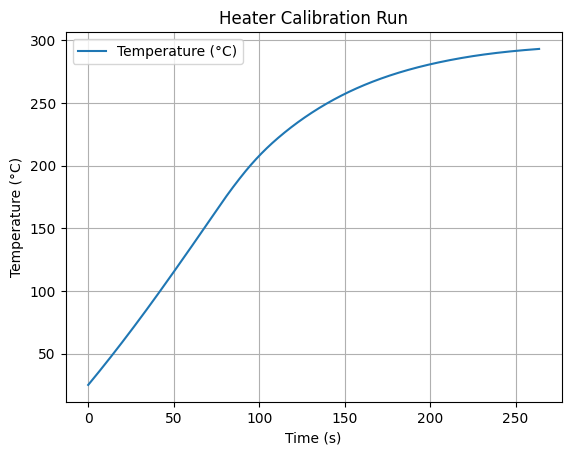

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration of the heater
from heater_configs import heaters as cfg

heater = cfg[0].clone().reset().scale_r_to(2.5).set_size(0.08, 0.07, 0.0028).label("80x70x2.8, 2.5R")

# Calibration run
temperature_data = []
time_data = []
power_data = []
dt = 0.1  # Time step in seconds

# Iterate until the rate of temperature increase is less than 0.1 °C/sec
heater.reset().set_power(100)
while True:
    heater.iterate(dt)
    
    temperature_data.append(heater.temperature)
    time_data.append(len(time_data) * dt)
    power_data.append(heater.get_power())  # Save the actual power

    # Calculate rate of temperature increase
    if len(temperature_data) > 1:
        rate_of_increase = (temperature_data[-1] - temperature_data[-2]) / dt
        if rate_of_increase < 0.1:
            break

# Estimate τ (time constant)
final_temp = temperature_data[-1]
τ_index = next(i for i, t in enumerate(temperature_data) if t >= final_temp * 0.63)
τ = time_data[τ_index]

# Calculate beta1 and beta2
beta1 = 2.2 / τ
beta2 = 1.1 / (τ ** 2)

# Helper, the derivative of temperature with respect to time
dT_dt = np.gradient(temperature_data, time_data)

# b0 = max derivative / power at that point
b0 = np.max(dT_dt) / power_data[np.argmax(dT_dt)]

# kr = ΔT / ΔP
kr = (temperature_data[τ_index] - heater.get_room_temp()) / power_data[τ_index]

# Output the calculated coefficients
print(f"τ: {τ:.4f} s")
print(f"T @ τ: {temperature_data[τ_index]:.2f} C")
print(f"b0: {b0:.4f}")
print(f"beta1: {beta1:.4f}")
print(f"beta2: {beta2:.6f}")
print(f"kr: {kr:.4f}")
print(f"kr alternate, via b0: {(1 / (b0 * τ)):.4f}")

# Plotting the temperature curve
plt.plot(time_data, temperature_data, label="Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Heater Calibration Run")
plt.legend()
plt.grid(True)
plt.show()


e: 25.0000, z1: 3.2000, z2: 144.3870, u: 7271.3303, u_output: 62.5000
e: 21.9646, z1: 20.4502, z2: 128.5180, u: -838.5525, u_output: 0.0000
e: 4.7144, z1: 33.9054, z2: 115.1699, u: -679.5815, u_output: 0.0000
e: -8.7409, z1: 44.3035, z2: 104.8546, u: -501.9965, u_output: 0.0000
e: -19.1391, z1: 52.3392, z2: 96.8829, u: -364.7593, u_output: 0.0000
e: -27.1748, z1: 58.5491, z2: 90.7225, u: -258.7030, u_output: 0.0000
e: -33.3848, z1: 63.3481, z2: 85.9617, u: -176.7430, u_output: 0.0000
e: -38.1838, z1: 67.0567, z2: 82.2826, u: -113.4045, u_output: 0.0000
e: -41.8925, z1: 69.9228, z2: 79.4394, u: -64.4568, u_output: 0.0000
e: -44.7586, z1: 72.1376, z2: 77.2422, u: -26.6302, u_output: 0.0000
e: -46.9735, z1: 73.8492, z2: 75.4925, u: 2.6021, u_output: 2.6021
e: -48.6783, z1: 75.1676, z2: 73.6792, u: 27.9965, u_output: 27.9965
e: -49.9231, z1: 76.1454, z2: 72.0212, u: 72.7028, u_output: 62.5682
e: -50.7362, z1: 76.8533, z2: 71.3181, u: 122.2498, u_output: 62.6141
e: -51.2793, z1: 77.4214, z2

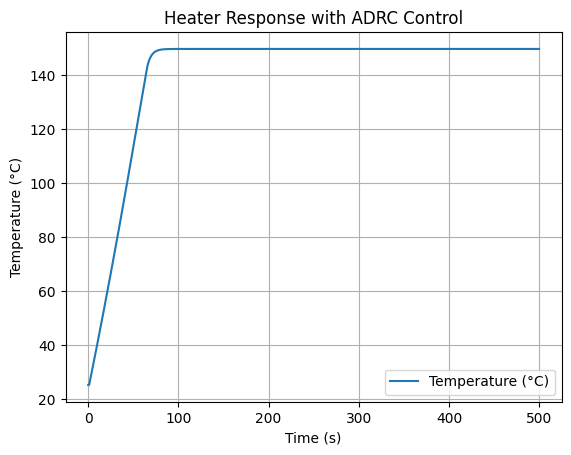

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from adrc import ADRC

heater = cfg[0].clone().reset().scale_r_to(2.5).set_size(0.08, 0.07, 0.0028).label("80x70x2.8, 2.5R")

# Use calibrated parameters
b0 = 0.0199
beta1 = 0.0256 * 50
beta2 = 0.000149 * 2500
kr = 1.6617 * 30

# Create an instance of the ADRC controller with calibrated parameters
adrc = ADRC(b0=b0, beta1=beta1, beta2=beta2, kp=kr)
adrc.reset_to(heater.get_room_temp())

setpoint = 150

temperature_data = []
time_data = []
power_data = []
dt = 0.1  # Time step in seconds
time_end = 500  # Simulation period
time_data = np.arange(0, time_end, dt)

# Simulation loop
for t in time_data:
    power_output = adrc.update(y=heater.temperature, y_ref=setpoint, u_max=heater.get_max_power(), dt=dt)
    heater.set_power(power_output)
    heater.iterate(dt)
    
    # Collect data for plotting
    temperature_data.append(heater.temperature)
    power_data.append(power_output)

# Plotting the results
plt.plot(time_data, temperature_data, label="Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Heater Response with ADRC Control")
plt.legend()
plt.grid(True)
plt.show()
